## Classifying Fashion-MNIST
Now it's your turn to build and train a neural network. You'll be using the Fashion-MNIST dataset, a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world.

<img src='assets/fashion-mnist-sprite.png' width=500px>

In this notebook, you'll build your own neural network. For the most part, you could just copy and paste the code from Part 3, but you wouldn't be learning. It's important for you to write the code yourself and get it to work. Feel free to consult the previous notebooks though as you work through this.

First off, let's load the dataset through torchvision.

In [1]:
import torch 
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

26427392it [00:01, 13334454.03it/s]                              


Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 93027.84it/s]                            
0it [00:00, ?it/s]

Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:01, 3885516.59it/s]                             
0it [00:00, ?it/s]

Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 33875.15it/s]            

Extracting /tmp/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

torch.manual_seed(50)

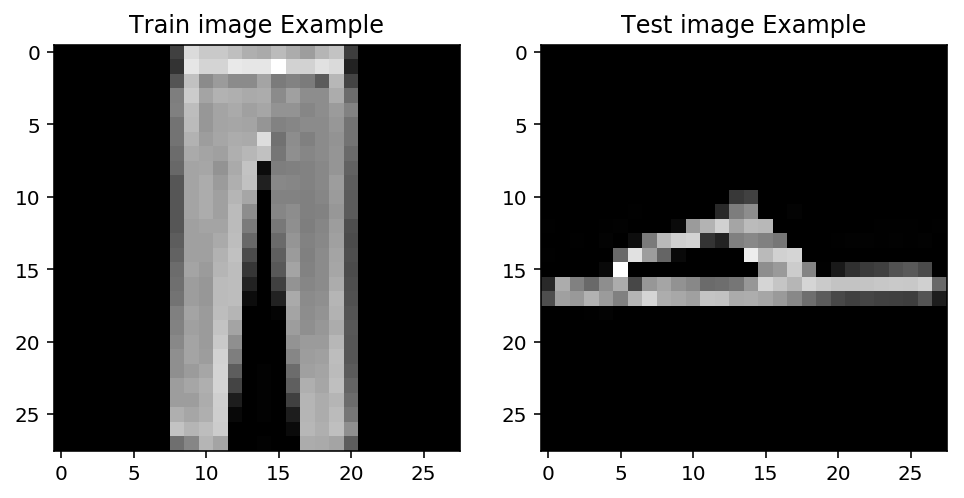

In [3]:
def get_example(dataloader, ax, i):
    images, labels = next(iter(dataloader))
    ax.imshow(images[0].numpy().squeeze(), cmap='Greys_r')
    if i==0:
        ax.set_title('Train image Example')
    else: 
        ax.set_title('Test image Example')


# check if data is loaded properly 
fig, ax = plt.subplots(figsize=(8, 6), ncols=2)
ax = ax.ravel()

for i, loader in enumerate((trainloader, testloader)):
    get_example(loader, ax[i], i)

plt.show();

## Building the network
Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [4]:
from torch import nn
import torch.nn.functional as F

# get a train example batch
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [5]:
class Network(nn.Module):
    
    def __init__(self, n_in, n_h, n_out):
        super().__init__()
        
        self.fc1 = nn.Linear(n_in, n_h)
        self.fc2 = nn.Linear(n_h, n_out)
    
    def forward(self, x):
        # flatten input image
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=1)

## Train the network
Now you should create your network and train it. First you'll want to define the criterion ( something like nn.CrossEntropyLoss) and the optimizer (typically optim.SGD or optim.Adam).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits
* Use the logits to calculate the loss
* Perform a backward pass through the network with loss.backward() to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

In [6]:
from torch import optim

# model hyperparams
n_in, n_h, n_out = (784, 256, 10)
# define model
model = Network(n_in, n_h, n_out)

# define optimizer and criterion 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# define criterion 
criterion = nn.NLLLoss() 

In [7]:
def train(model, epochs, optimizer, criterion):
    
    for epoch in range(epochs):
        running_loss_tr = 0
        
        for images, labels in trainloader:
            # zero the grads
            optimizer.zero_grad()

            # forward pass
            log_ps = model(images)

            # backward pass: calculate grads w.r.t loss
            loss = criterion(log_ps, labels)
            loss.backward()

            # add loss to running loss
            running_loss_tr += loss.item()

            # take an update step
            optimizer.step()
        
        running_loss = 0 
        for images, labels in testloader:
            with torch.no_grad():
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                running_loss += loss.item()

        print(
            f'Epoch: {epoch}\
            Train Loss: {running_loss_tr/len(trainloader)}\
            Test Loss: {running_loss/len(testloader)}'
            )

In [8]:
# training
train(model, 3, optimizer, criterion)

Epoch: 0            Train Loss: 0.48894407973487747            Test Loss: 0.4604043631227153
Epoch: 1            Train Loss: 0.37246636466494504            Test Loss: 0.3882129381226886
Epoch: 2            Train Loss: 0.33544016415789435            Test Loss: 0.3609252467656591


## Testing the Network

In [9]:
import numpy as np

# plot input and output
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

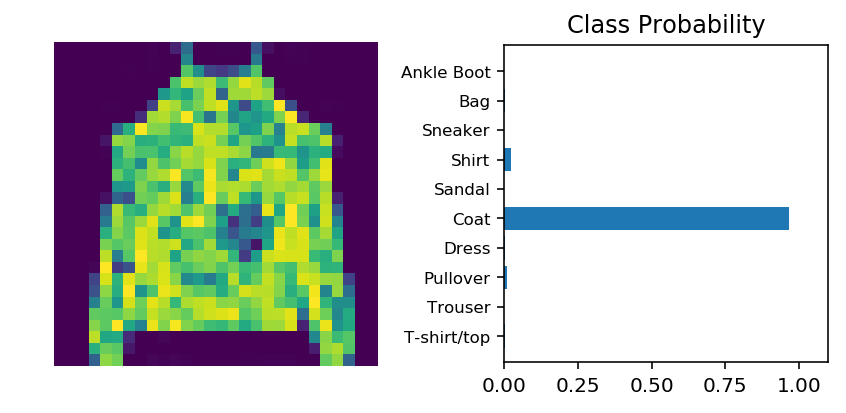

In [10]:
images, labels = next(iter(testloader))
img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# get probabilities
with torch.no_grad():
    ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.resize_(1, 28, 28), ps, version='Fashion')